
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
from tinnsleep.reports import combine_brux_MEMA
from tinnsleep.data import CreateRaw, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, create_list_events
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tinnsleep.config import Config

print("Config loaded")


Config loaded


## Loading parameters and results

In [2]:
EDF_list = Config.bruxisme_files

# Dictionnary of known names of the Airflow
mapping = {"Airflow": "MEMA"}

mema_files = pd.read_csv("data/mema_files.csv",engine='python', sep="; ")["files_with_mema"].values
print(mema_files[:3])

results_MEMA = pd.read_pickle("data/reports_and_datas_MEMA.pk").to_dict()
results_brux = pd.read_pickle("data/reports_and_datas_bruxism.pk").to_dict()
min_burst_joining_brux = 3 
min_burst_joining_MEMA = 0

['1DA15_nuit_son.edf' '1GB19_nuit_hab.edf' '1MF19_nuit_hab.edf']


## Bruxism + MEMA processing for pure MEMA visualisation

Interpolating non proportional list, expecting to have non-uniform shift across recording
Interpolating non proportional list, expecting to have non-uniform shift across recording


Files processed : 
1BA07_nuit_hab.edf not included
1BA07_nuit_son.edf not included
1CC05_nuit_hab.edf not included
1CC05_nuit_son.edf not included
1DA15_nuit_hab.edf not included
1DA15_nuit_son.edf 

Interpolating non proportional list, expecting to have non-uniform shift across recording
Interpolating non proportional list, expecting to have non-uniform shift across recording


rapport d'activité : 
nb episodes bruxisme combinés : 
0
Nb épisodes bruxisme purs : 
47
nb episodes MEMA combinés : 
2
Nb épisodes MEMA purs : 
20
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.0
Nb épisodes bruxisme purs : 
5.2229959994073205
nb episodes MEMA combinés : 
0.2222551489109498
Nb épisodes MEMA purs : 
2.222551489109498
1DL12_nuit_hab.edf not included
1DL12_nuit_son.edf not included
1GB18_nuit_son.edf not included
1GB19_nuit_hab.edf 

Interpolating non proportional list, expecting to have non-uniform shift across recording
Interpolating non proportional list, expecting to have non-uniform shift across recording


rapport d'activité : 
nb episodes bruxisme combinés : 
7
Nb épisodes bruxisme purs : 
44
nb episodes MEMA combinés : 
1
Nb épisodes MEMA purs : 
35
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.7930094330360177
Nb épisodes bruxisme purs : 
4.9846307219406825
nb episodes MEMA combinés : 
0.11328706186228824
Nb épisodes MEMA purs : 
3.9650471651800885
1GF14_nuit_hab.edf not included
1GF14_nuit_son.edf not included
1MF19_nuit_hab.edf rapport d'activité : 
nb episodes bruxisme combinés : 
6
Nb épisodes bruxisme purs : 
138
nb episodes MEMA combinés : 
3
Nb épisodes MEMA purs : 
48
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.6651294785384889
Nb épisodes bruxisme purs : 
15.297978006385243
nb episodes MEMA combinés : 
0.33256473926924446
Nb épisodes MEMA purs : 
5.321035828307911
1MF19_nuit_son.edf not included
1MN09_nuit_hab.edf not included
1MN09_nuit_son.edf not included
1PI07_nuit_hab.edf not included
1PI07_nuit_son.edf not included
1PT06

KeyError: '/Users/louis/Data/SIOPI/bruxisme/1RA17_nuit_hab.edf'

/Users/louis/anaconda3/envs/tinnsleep-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


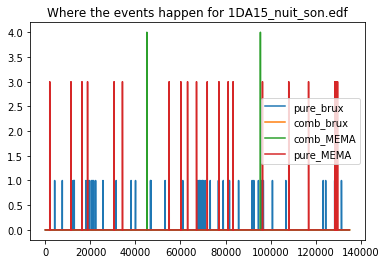

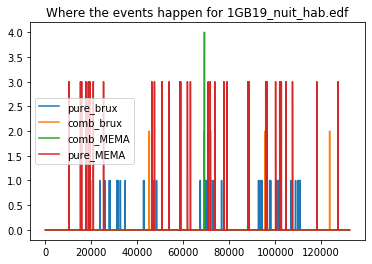

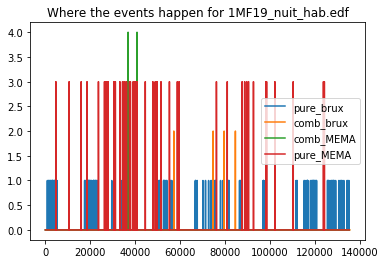

In [3]:
from time import time
# load file from config
filenames = EDF_list

start = time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in EDF_list:
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        print(file, end=" ")
        if not file in mema_files:
            print(f"not included")
        else:
            window_length_brux = results_brux[filename]["parameters"]["time_interval"]
            delim_brux = results_brux[filename]["parameters"]["delim"]
            window_length_MEMA = results_MEMA[filename]["parameters"]["time_interval"]
            delim_MEMA = results_MEMA[filename]["parameters"]["delim"]
            params_combine = dict(
                                labels_brux = results_brux[filename]["labels"][0], 
                                labels_artifacts_brux = results_brux[filename]["parameters"]["valid_labels"], 
                                time_interval_brux = results_brux[filename]["parameters"]["time_interval"], 
                                delim_ep_brux = results_brux[filename]["parameters"]["delim"], 
                                labels_MEMA = results_MEMA[filename]["labels"][0],
                                labels_artifacts_MEMA = results_MEMA[filename]["parameters"]["valid_labels"],
                                time_interval_MEMA = results_MEMA[filename]["parameters"]["time_interval"],
                                delim_ep_MEMA = results_brux[filename]["parameters"]["delim"],
                                min_burst_joining_brux=min_burst_joining_brux, 
                                min_burst_joining_MEMA=min_burst_joining_MEMA
                                )
    
            brux_comb_ep, brux_pure_ep, compt_arti_brux, MEMA_comb_ep, MEMA_pure_ep, compt_arti_MEMA = combine_brux_MEMA(**params_combine)
    
            pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
            li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= min_burst_joining_brux)
            pure_brux_events = create_list_events(li_ep_brux_p, window_length_brux, len(brux_pure_ep) * window_length_brux)
    
            comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
            li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= min_burst_joining_brux)
            comb_brux_events = create_list_events(li_ep_brux_c, window_length_brux, len(brux_comb_ep) * window_length_brux)
            
            comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux) # window_length_brux is valid ?
            
            pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux) # window_length_brux is valid ?
            
            print("rapport d'activité : ")
            print("nb episodes bruxisme combinés : ")
            print(len(li_ep_brux_c))
            print("Nb épisodes bruxisme purs : ")
            print(len(li_ep_brux_p))
            print("nb episodes MEMA combinés : ")
            print(len(comb_MEMA_bursts))
            print("Nb épisodes MEMA purs : ")
            print(len(pure_MEMA_bursts))
            
            print("rapport d'activité taux horaire : ")
            print("nb episodes bruxisme combinés : ")
            print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("Nb épisodes bruxisme purs : ")
            print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("nb episodes MEMA combinés : ")
            print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("Nb épisodes MEMA purs : ")
            print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            
            for i in range(len(MEMA_comb_ep)):
                if MEMA_comb_ep[i]>0:
                    MEMA_comb_ep[i]+=3
            
            for i in range(len(MEMA_pure_ep)):
                if MEMA_pure_ep[i]>0:
                    MEMA_pure_ep[i]+=2
                    
            for i in range(len(comb_brux_events)):
                if comb_brux_events[i]>0:
                    comb_brux_events[i]+=1
                    
            plt.figure()
            plt.plot(pure_brux_events, label="pure_brux")
            plt.plot(comb_brux_events, label="comb_brux")
            plt.plot(MEMA_comb_ep, label="comb_MEMA")
            plt.plot(MEMA_pure_ep, label="pure_MEMA")
            plt.legend()
            plt.title("Where the events happen for " + file)
                        
                       

In [ ]:
         
#-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
#Preparing raw for visualisation
picks_chan = ['Airflow', '1', '2']           # subset of EMG electrodes
raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types='emg')        # pick channels and load
raw  = raw.load_data()
dat=raw.get_data()
dat[1]=[dat[1][i]*1/(0.0005) for i in range(len(dat[1]))]
dat[2]=[dat[2][i]*1/(0.0005) for i in range(len(dat[2]))]
raw  = CreateRaw(dat, raw.info["sfreq"], picks_chan, ch_types='emg') 

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])

#Annotating the raw
raw = CleanAnnotations(raw)
dict_annotations = {1: "b_pure", 2:"b_comb", 3:"M_pure", 4:"M_comb"}
raw = AnnotateRaw_sliding(raw, MEMA_comb_ep , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)

raw = AnnotateRaw_sliding(raw, comb_brux_events , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)
raw = AnnotateRaw_sliding(raw, pure_brux_events , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)
raw = AnnotateRaw_sliding(raw, MEMA_pure_ep , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)
print("Raw annotated")
raw.plot(scalings = "auto")
plt.title(filename)
                    